In [4]:
!pip install Keras
import time
import numpy as np
import pandas as pd
#import dill as pkl
import pickle as pkl
from matplotlib import pyplot as plt
from collections import defaultdict
import nltk
import re
import itertools
import unittest
import RegexTester
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet
%matplotlib inline
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model, load_model, Sequential
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, optimizers
from keras.callbacks import History, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, auc

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# LOAD Pre-processed DATA from Analysis notebook

In [2]:
full_data = pd.read_pickle("./full_data.pkl")

# TRAIN/TEST SPLIT

In [5]:
train_set, test_set = train_test_split(full_data, test_size=0.10, random_state=42)

#Separate training set into train and dev. Roughly 80% of original data is train, 10% dev, 10% test
train_set, dev_set = train_test_split(train_set, test_size=0.11, random_state=42)

# BoW TFIDF

In [6]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(full_data["list_genres_consol"])

MAX_NB_WORDS = 80000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_set['flattened_tokens'])

In [7]:
x_train_bow = tokenizer.texts_to_matrix(train_set["flattened_tokens"], mode="tfidf")
print(x_train_bow.shape)
x_dev_bow = tokenizer.texts_to_matrix(dev_set["flattened_tokens"], mode="tfidf")
print(x_dev_bow.shape)
x_test_bow = tokenizer.texts_to_matrix(test_set["flattened_tokens"], mode = "tfidf")
print(x_test_bow.shape)

(179666, 80000)
(22206, 80000)
(22431, 80000)


In [16]:
model = Sequential()
model.add(Dense(100, input_shape=(x_train_bow.shape[1],), activation='tanh'))
model.add(Dense(mlb.classes_.shape[0], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])
model.fit(x_train_bow, np.stack(train_set["binarized_labels"]), epochs = 10, batch_size = 10000)

Epoch 1/10
179666/179666 [==============================] - 144s 799us/step - loss: 0.3802 - acc: 0.8440
Epoch 2/10
179666/179666 [==============================] - 144s 800us/step - loss: 0.2649 - acc: 0.8947
Epoch 3/10
179666/179666 [==============================] - 143s 796us/step - loss: 0.2306 - acc: 0.9090
Epoch 4/10
179666/179666 [==============================] - 143s 795us/step - loss: 0.2066 - acc: 0.9193
Epoch 5/10
179666/179666 [==============================] - 143s 797us/step - loss: 0.1876 - acc: 0.9284
Epoch 6/10
179666/179666 [==============================] - 143s 798us/step - loss: 0.1718 - acc: 0.9357
Epoch 7/10
179666/179666 [==============================] - 143s 796us/step - loss: 0.1584 - acc: 0.9419
Epoch 8/10
179666/179666 [==============================] - 143s 798us/step - loss: 0.1469 - acc: 0.9473
Epoch 9/10
179666/179666 [==============================] - 143s 797us/step - loss: 0.1367 - acc: 0.9519
Epoch 10/10
179666/179666 [============================

In [18]:
preds = model.predict(x_dev_bow)

In [27]:
from keras.models import load_model
model.save("BOW_tfidf_100dim_10kbatch.h5")

# EVAL METRICS

In [19]:
def indiv_class_scores(y_true, y_pred, threshold, metric = None):
    y_pred = y_pred >= threshold
    for i in range(len(mlb.classes_)):
        if metric == "precision":
            score = precision_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        elif metric == "recall":
            score = recall_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        elif metric == "f1":
            score = f1_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        else:
            return "Not a valid metric"

In [21]:
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds, threshold = 0.5, metric = "precision")
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds, threshold=0.5, metric = "recall")
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds, threshold= 0.5, metric= "f1")

The precision for Action is 0.5737704918032787
The precision for Adventure is 0.5289017341040463
The precision for Comedy is 0.6805076778439361
The precision for Crime is 0.5335786568537259
The precision for Drama is 0.7062103929024081
The precision for Family is 0.5303030303030303
The precision for Horror is 0.6755994358251057
The precision for Romance is 0.4307795698924731
The precision for Sci-Fi is 0.7091295116772823
The precision for Thriller is 0.4425319267073848
The recall for Action is 0.4221954161640531
The recall for Adventure is 0.3053392658509455
The recall for Comedy is 0.6143726128165229
The recall for Crime is 0.3111587982832618
The recall for Drama is 0.7250173490631506
The recall for Family is 0.3172709923664122
The recall for Horror is 0.48530901722391084
The recall for Romance is 0.2351430667644901
The recall for Sci-Fi is 0.4510465901417961
The recall for Thriller is 0.2823237690400283
The f1 for Action is 0.4864489228630994
The f1 for Adventure is 0.387165021156558

In [23]:
y_pred = preds >= 0.5
micro_precision = precision_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_precision = precision_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
micro_recall = recall_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_recall = recall_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
micro_f1 = f1_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_f1 = f1_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)


The micro precision is 0.6400343938091143
The weighted macro precision is 0.6205202062354715
The micro recall is 0.5191374211906489
The weighted macro recall is 0.5191374211906489
The micro f1 is 0.5732813727453366
The weighted macro f1 is 0.5584406367955116


In [24]:
def auc_pr(y_true, y_pred):
    scores = []
    for i in range(len(mlb.classes_)):
        p, r, d = precision_recall_curve(y_true[:,i], y_pred[:,i])
        score = auc(r,p)
        scores.append(score)
        print("The AUC for {} is {}".format(mlb.classes_[i], score))
    macro_score = np.mean(scores)
    y_true_raveled = np.ravel(y_true)
    y_pred_raveled = np.ravel(y_pred)
    p, r, d = precision_recall_curve(y_true_raveled, y_pred_raveled)
    micro_score = auc(r,p)
    print("The micro-avg AUC is {}".format(micro_score))
    print("The macro-avg AUC is {}".format(macro_score))

auc_pr(np.stack(dev_set["binarized_labels"]), preds)

The AUC for Action is 0.5163846595510063
The AUC for Adventure is 0.39430045355531806
The AUC for Comedy is 0.7200882911332489
The AUC for Crime is 0.41472152644324606
The AUC for Drama is 0.7539749320764856
The AUC for Family is 0.44027039078746344
The AUC for Horror is 0.6114856955684589
The AUC for Romance is 0.33176161535522886
The AUC for Sci-Fi is 0.5880351494945427
The AUC for Thriller is 0.37894109698092066
The micro-avg AUC is 0.620593828076398
The macro-avg AUC is 0.5149963810945919


# Load Word Embeddings

In [2]:
def loadEmbed(file):
    start = time.time()
    print("Loading Embeddings")
    f = open(file, 'r', encoding='utf-8')
    model = {}
    status_every = 100000
    for i, line in enumerate(f):
        if i%status_every == 0:
            print('Processing line {:,}'.format(i))
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",'{:,}'.format(len(model))," words loaded!")
    end = time.time()
    print("Total Time to load embeddings:", end - start, "seconds")
    return model

In [3]:
#TOO LARGE TO PUSH TO GIT, DOWNLOAD SEPARATLEY FROM https://github.com/stanfordnlp/GloVe
glove_dir = './glove.6B/'
glove_filename = 'glove.6B.300d.txt'
glove_fullpath = glove_dir + glove_filename
glove_dd = loadEmbed(glove_fullpath)

Loading Embeddings
Processing line 0
Processing line 100,000
Processing line 200,000
Processing line 300,000
Processing line 400,000
Done. 400,001  words loaded!
Total Time to load embeddings: 42.814167976379395 seconds


# Read Full Data and Generate Embeddings for BOW

In [8]:
full_data["plot_lengths"] = full_data["flattened_tokens"].apply(lambda row: len(row))

61.0


(array([7.0940e+03, 1.0725e+05, 7.3764e+04, 4.0858e+04, 1.9968e+04,
        6.4460e+03, 3.8200e+02, 4.9000e+01, 3.4000e+01, 8.0000e+00]),
 array([  4. ,  22.4,  40.8,  59.2,  77.6,  96. , 114.4, 132.8, 151.2,
        169.6, 188. ]),
 <a list of 10 Patch objects>)

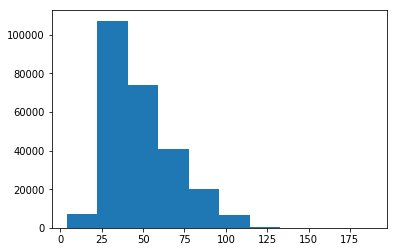

In [41]:
print(np.percentile(full_data["plot_lengths"],75))
plt.hist(full_data["plot_lengths"])

In [126]:
def embed_plot_BOW(plot):
    word_embeddings = np.array([glove_dd.get(word, glove_dd.get("unk")) for word in plot]).astype(np.float32)
    sentence_embedding = [sum(dim) for dim in zip(*word_embeddings)]
    return np.array(sentence_embedding)

In [128]:
print("Embedding plots...")
start = time.time()
full_data["flattened_embeddings"] = full_data["flattened_tokens"].apply(lambda row: embed_plot_BOW(row))
end = time.time()
print("Total Time to embed plots:", end - start, "seconds")

Embedding plots...
Total Time to embed plots: 813.7513613700867 seconds


In [129]:
full_data.to_pickle("./full_data_w_flattened_embeddings.pkl")

In [9]:
full_data = pd.read_pickle("./full_data_w_flattened_embeddings.pkl")

In [10]:
full_data_sample = full_data.iloc[0:2] #sample to start with

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(full_data["flattened_embeddings"], 
                                                    full_data["binarized_labels"], test_size=0.20, random_state=42)
#x_train = np.stack(full_data_sample["flattened_embeddings"].values)

In [12]:
X_train_sample = np.stack(X_train[0:100].values)
y_train_sample = np.stack(y_train[0:100].values)
X_test_sample = np.stack(X_test[0:100].values)
y_test_sample = np.stack(y_test[0:100].values)
X_train = np.stack(X_train.values)
y_train = np.stack(y_train.values)
X_test = np.stack(X_test.values)
y_test = np.stack(y_test.values)

# MODEL

In [13]:
model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1],), activation='tanh'))
model.add(Dense(mlb.classes_.shape[0], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])
model.fit(X_train, y_train, epochs = 5, batch_size = 100)
preds = model.predict(X_test)

Epoch 1/5
204682/204682 [==============================] - 8s 41us/step - loss: 0.2120 - acc: 0.9198
Epoch 2/5
204682/204682 [==============================] - 7s 33us/step - loss: 0.1981 - acc: 0.9236
Epoch 3/5
204682/204682 [==============================] - 7s 34us/step - loss: 0.1961 - acc: 0.9242
Epoch 4/5
204682/204682 [==============================] - 7s 33us/step - loss: 0.1951 - acc: 0.9245
Epoch 5/5
204682/204682 [==============================] - 7s 33us/step - loss: 0.1943 - acc: 0.9248


# BI_DIRECTIONAL LSTM

In [34]:
embedding_matrix = np.load("embed_matrix.npy")

In [66]:
MAX_NB_WORDS = 80000
EMBEDDING_DIM = 100
MAX_SENT_LENGTH = 15
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

embedding_layer = Embedding(MAX_NB_WORDS + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=75,
                            embeddings_regularizer=l2_reg,
                            mask_zero = True, #determines whether masking is performed, i.e. whether the layers ignore the padded zeros in shorter documents
                            trainable=False) 

tokenizer = Tokenizer(num_words=MAX_NB_WORDS+1, oov_token='UNK')
tokenizer.fit_on_texts(full_data['flattened_tokens'])

In [67]:
MAX_SENTS = 5
data = np.zeros((len(full_data), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
doc_lst = []

# keep the MAX_NB_WORDS most frequent words and replace the rest with 'UNK'
# truncate to the first MAX_SENTS sentences per doc and MAX_SENT_LENGTH words per sentence

for summary_num, row in full_data.iterrows():
    for sent_num, sent in enumerate(row['tokenized_words']):
        if sent_num < MAX_SENTS:
            #wordTokens = text_to_word_sequence(sent)
            word_num = 0
            words_in_sent = []
            for _, word in enumerate(sent):
                if word_num < MAX_SENT_LENGTH: 
                    if (word in tokenizer.word_index) and (tokenizer.word_index[word] <= MAX_NB_WORDS):
                        data[summary_num, sent_num, word_num] = tokenizer.word_index[word]
                        words_in_sent.append(word)
                    else:
                        data[summary_num, sent_num, word_num] = MAX_NB_WORDS
                        words_in_sent.append('UNK')
                    word_num = word_num + 1
            doc_lst.append(words_in_sent)

In [68]:
lstm_plot_data = data.reshape(len(full_data), -1) #collapse sentence length and max sents into single dimension
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(lstm_plot_data, 
                                                    full_data["binarized_labels"], test_size=0.20, random_state=42)

# X_train_lstm = np.stack(X_train_lstm.values)
y_train_lstm = np.stack(y_train_lstm.values)
# X_test_lstm = np.stack(X_test_lstm.values)
y_test_lstm = np.stack(y_test_lstm.values)

In [72]:
input_layer = Input(shape=(X_train_lstm.shape[1],), dtype='int32')
embedded_plot = embedding_layer(input_layer)
bilstm_layer = Bidirectional(LSTM(100))(embedded_plot)
output_layer = Dense(units=mlb.classes_.shape[0], activation="sigmoid")(bilstm_layer)
LSTM_model = Model(inputs=input_layer, outputs= output_layer)
LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])
LSTM_model.fit(X_train_lstm, y_train_lstm, epochs = 1, batch_size = 100)
preds_LSTM = LSTM_model.predict(X_test_lstm)

Epoch 1/1
204682/204682 [==============================] - 1319s 6ms/step - loss: 0.2538 - acc: 0.9111


In [73]:
indiv_class_scores(y_test_lstm, preds_LSTM, threshold = 0.5, metric = "precision")

The precision for Action is 0.6
The precision for Adventure is 0.5
The precision for Animation is 0.7567567567567568
The precision for Biography is 0.5192307692307693
The precision for Comedy is 0.6819727891156463
The precision for Crime is 0.4148936170212766
The precision for Drama is 0.6397024397856734
The precision for Family is 0.0
The precision for Fantasy is 0.0
The precision for History is 0.5517241379310345
The precision for Horror is 1.0
The precision for Music is 0.7223719676549866
The precision for Musical is 0.0
The precision for Mystery is 0.0
The precision for Romance is 0.5348837209302325
The precision for Sci-Fi is 0.7784810126582279
The precision for Sport is 0.6666666666666666
The precision for Thriller is 0.5586206896551724
The precision for War is 0.5291479820627802
The precision for Western is 0.0


/home/sharadv/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [74]:
indiv_class_scores(y_test_lstm, preds_LSTM, threshold = 0.5, metric = "recall")

The recall for Action is 0.009626955475330927
The recall for Adventure is 0.0005635390250774866
The recall for Animation is 0.017789072426937738
The recall for Biography is 0.010044642857142858
The recall for Comedy is 0.13960451190641973
The recall for Crime is 0.01047823750671682
The recall for Drama is 0.5216118769883351
The recall for Family is 0.0
The recall for Fantasy is 0.0
The recall for History is 0.006415396952686447
The recall for Horror is 0.0018036588508116465
The recall for Music is 0.3182897862232779
The recall for Musical is 0.0
The recall for Mystery is 0.0
The recall for Romance is 0.02459016393442623
The recall for Sci-Fi is 0.043647977288857345
The recall for Sport is 0.0016992353440951572
The recall for Thriller is 0.014263074484944533
The recall for War is 0.07914151576123407
The recall for Western is 0.0


In [75]:
indiv_class_scores(y_test_lstm, preds_LSTM, threshold = 0.5, metric = "f1")

The f1 for Action is 0.0189498618239242
The f1 for Adventure is 0.001125809175344779
The f1 for Animation is 0.03476101800124147
The f1 for Biography is 0.01970802919708029
The f1 for Comedy is 0.2317651138596694
The f1 for Crime is 0.020440251572327043
The f1 for Drama is 0.5746530211692135
The f1 for Family is 0.0
The f1 for Fantasy is 0.0
The f1 for History is 0.012683313515655966
The f1 for Horror is 0.0036008230452674894
The f1 for Music is 0.4418796372629843
The f1 for Musical is 0.0
The f1 for Mystery is 0.0
The f1 for Romance is 0.047018739352640546
The f1 for Sci-Fi is 0.08266129032258064
The f1 for Sport is 0.0033898305084745766
The f1 for Thriller is 0.027815934065934064
The f1 for War is 0.13768961493582263
The f1 for Western is 0.0


/home/sharadv/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [76]:
y_pred_LSTM = preds_LSTM >= 0.5
micro_precision = precision_score(y_test_lstm, y_pred_LSTM, average = 'micro')
weighted_macro_precision = precision_score(y_test_lstm, y_pred_LSTM, average = 'weighted')
micro_recall = recall_score(y_test_lstm, y_pred_LSTM, average = 'micro')
weighted_macro_recall = recall_score(y_test_lstm, y_pred_LSTM, average = 'weighted')
micro_f1 = f1_score(y_test_lstm, y_pred_LSTM, average = 'micro')
weighted_macro_f1 = f1_score(y_test_lstm, y_pred_LSTM, average = 'weighted')

/home/sharadv/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sharadv/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [77]:
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)

The micro precision is 0.6459451706757365
The weighted macro precision is 0.5534187077225805
The micro recall is 0.16780216738699993
The weighted macro recall is 0.16780216738699993
The micro f1 is 0.2663996417133538
The weighted macro f1 is 0.2048039333371301
